# Gibbs sampling
> Programmatic introduction

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

#### Imports

In [1]:
import networkx as nx
import itertools
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
import daft
import random
import requests
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#### Defining the network

In [2]:
network={
    "V": ["Letter", "Grade", "Intelligence", "SAT", "Difficulty"],
    "E": [["Intelligence", "Grade"],
        ["Difficulty", "Grade"],
        ["Intelligence", "SAT"],
        ["Grade", "Letter"]],
    "Vdata": {
        "Letter": {
            "ord": 4,
            "numoutcomes": 2,
            "vals": ["weak", "strong"],
            "parents": ["Grade"],
            "children": None,
            "cprob": {
                "['A']": [.1, .9],
                "['B']": [.4, .6],
                "['C']": [.99, .01]
            }
        },

        "SAT": {
            "ord": 3,
            "numoutcomes": 2,
            "vals": ["lowscore", "highscore"],
            "parents": ["Intelligence"],
            "children": None,
            "cprob": {
                "['low']": [.95, .05],
                "['high']": [.2, .8]
            }
        },

        "Grade": {
            "ord": 2,
            "numoutcomes": 3,
            "vals": ["A", "B", "C"],
            "parents": ["Difficulty", "Intelligence"],
            "children": ["Letter"],
            "cprob": {
                "['easy', 'low']": [.3, .4, .3],
                "['easy', 'high']": [.9, .08, .02],
                "['hard', 'low']": [.05, .25, .7],
                "['hard', 'high']": [.5, .3, .2]
            }
        },

        "Intelligence": {
            "ord": 1,
            "numoutcomes": 2,
            "vals": ["low", "high"],
            "parents": None,
            "children": ["SAT", "Grade"],
            "cprob": [.7, .3]
        },

        "Difficulty": {
            "ord": 0,
            "numoutcomes": 2,
            "vals": ["easy", "hard"],
            "parents": None,
            "children": ["Grade"],
            "cprob":  [.6, .4]
        }
    }
}

#### Drawing the Bayesian Network

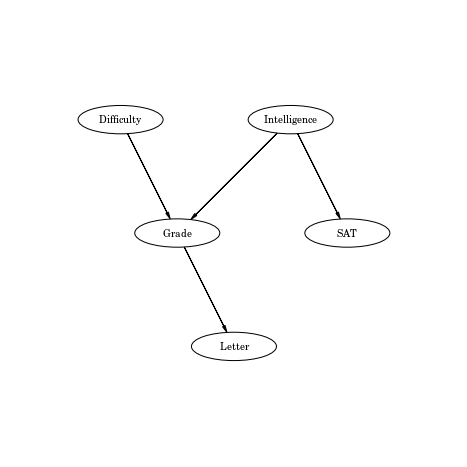

In [3]:
pgm = daft.PGM([8, 8], origin=[0, 0])

pgm.add_node(daft.Node('Difficulty',r"Difficulty",2,6,aspect=3))   
pgm.add_node(daft.Node('Intelligence',r"Intelligence",5,6,aspect=3))
pgm.add_node(daft.Node('Grade',r"Grade",3,4,aspect=3))    
pgm.add_node(daft.Node('SAT',r"SAT",6,4,aspect=3))    
pgm.add_node(daft.Node('Letter',r"Letter",4,2,aspect=3))   

for node in network['Vdata']:
    parents=network['Vdata'][node]['parents']
    if parents is not None:        
        for parent in parents:
            pgm.add_edge(parent, node) 
pgm.render()

#### Finding the Markov blanket of a node

In [4]:
def find_markov_blanket(node,network):
    '''
    Find the Markov Blanket of the node in the given network
    Markov Blanket is given by:
    1. The parents of the node
    2. The children of the node
    3. The parents of the children of the node
    '''
    
    mb=[]
    #Finding the parents of the node
    parents=network['Vdata'][node]['parents']
    if parents is not None:
        mb.append(parents)
    
    #Finding children of the node
    children=network['Vdata'][node]['children']
    if children is not None:
        mb.append(children)
        
        #Finding parent of each node
        for child in children:
            parents_child=network['Vdata'][child]['parents']
            if parents is not None:
                mb.append(parents)
                
    #Flattening out list of lists
    mb=list(itertools.chain(*mb)) 
    
    #Removing repeated elements
    mb=list(set(mb))
    return mb

In [5]:
find_markov_blanket('Grade',network)

['Difficulty', 'Letter', 'Intelligence']

#### Gibbs Sampling Procedures

#### Assigning a random state to a node in the network

In [6]:
def pick_random(node,network):
    '''
    Assigns a random state to a given node
    N
    '''
    num_outcomes=network['Vdata'][node]["numoutcomes"]
    random_index=random.randint(0,num_outcomes-1)
    return network['Vdata'][node]["vals"][random_index]

In [7]:
pick_random('SAT',network)

'lowscore'

#### Pick a random non evidence node to the update in the current iteration 

In [8]:
def pick_random_non_evidence_node(non_evidence_nodes):
    return non_evidence_nodes[random.randint(0,len(non_evidence_nodes)-1)]

#### Update the value of a node given assignment in previous iteration

In [9]:
def get_next_value(node, network,simulation):
    parents_current_node_to_update=network['Vdata'][node]['parents']
    if parents_current_node_to_update is None:
        #The node has no parent and we can update it based on the prior
        cumsum=np.cumsum(network['Vdata'][node]["cprob"])    
    else:
        #Find the row corresponding to the values of the parents in the previous iteration
        #NB We need to maintain the order, so we will do it 
        values_parents=[simulation[-1][parent] for parent in parents_current_node_to_update]
        row=network['Vdata'][node]["cprob"][str(values_parents)]
        cumsum=np.cumsum(row)
    choice=random.random()
    index=np.argmax(cumsum>choice)
    return network['Vdata'][node]["vals"][index]
    

#### Main procedure: Iteratively pick up a non evidence node to update

In [10]:
def gibbs_sampling(network, evidence, niter=2):
    simulation=[]
    nodes=network['V']
    non_evidence_nodes=[node for node in nodes if node not in evidence.keys()]        
    #First iteration random value for all nodes
    d={}
    for node in nodes:
        d[node]=pick_random(node,network)    
    #Put evidence
    for node in evidence:
        d[node]=evidence[node]        
    simulation.append(d.copy())        
    #Now iterate 
    for count in xrange(niter):
        #Pick up a random node to start
        current_node_to_update=pick_random_non_evidence_node(non_evidence_nodes)
        d[current_node_to_update]=get_next_value(current_node_to_update,network,simulation)
        simulation.append(d.copy())
    return simulation      

##### Illustration 1

#### Distribution of Letter given that the student is Intelligent

In [11]:
iterations=int(1e4)
sim=gibbs_sampling(network, {"Intelligence":"high"},iterations)

Removing first 10% samples

In [12]:
after_removing_burnt_samples=sim[iterations/10:]
count={val:0 for val in network['Vdata']['Letter']['vals']}

Finding the distribution of letter

In [13]:
for assignment in after_removing_burnt_samples:
    count[assignment['Letter']]+=1    

Counts

In [14]:
count

{'strong': 7061, 'weak': 1940}

Counts to Probabilites

In [15]:
probabilites={}
for l in count:
    probabilites[l]=count[l]*1.0/(.90*iterations)
probabilites

{'strong': 0.7845555555555556, 'weak': 0.21555555555555556}

#### Wait a min! What about the marginal distribution of Letter given NO evidence

In [16]:
iterations=int(1e4)
sim=gibbs_sampling(network, {},iterations)
after_removing_burnt_samples=sim[iterations/10:]
count={val:0 for val in network['Vdata']['Letter']['vals']}
for assignment in after_removing_burnt_samples:
    count[assignment['Letter']]+=1
probabilites_no_evidence={}
for l in count:
    probabilites_no_evidence[l]=count[l]*1.0/(.90*iterations)
probabilites_no_evidence

{'strong': 0.4766666666666667, 'weak': 0.5234444444444445}

#### How does the evidence about "Intelligent" student affect the quality of letters?

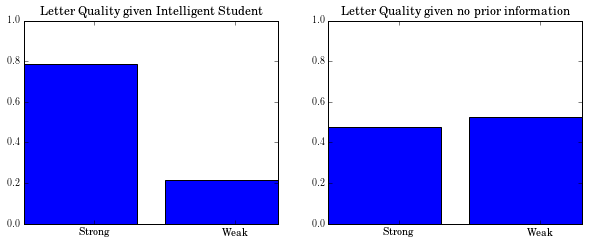

In [17]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.bar(range(2),[probabilites['strong'],probabilites['weak']])
plt.xticks([0.5,1.5],['Strong','Weak'])
plt.title('Letter Quality given Intelligent Student')
plt.ylim((0,1.0))
plt.subplot(2,2,2)
plt.bar(range(2),[probabilites_no_evidence['strong'],probabilites_no_evidence['weak']])
plt.xticks([0.5,1.5],['Strong','Weak'])
plt.title('Letter Quality given no prior information')
plt.ylim((0,1.0));